# Data Exploration

### Import necessary packages

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

% matplotlib inline

# feature engineering
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder as le

# model training
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# model evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# classifiers
from sklearn.neighbors import KNeighborsClassifier # KNN
from sklearn.linear_model import LogisticRegression # logistic regression
from sklearn.tree import DecisionTreeClassifier # decision tree
from sklearn.ensemble import RandomForestClassifier # random forest
from sklearn.ensemble import GradientBoostingClassifier # gradient boosting

UsageError: Line magic function `%` not found.


### Read CSV File

In [26]:
df = pd.read_csv('data/loan.csv',low_memory=True)
df.head()

/Users/chihongtao/anaconda/envs/notebook/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (19,47,55,112,123,124,125,128,129,130,133,139,140,141) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,2500,2500,2500.0,36 months,13.56,84.92,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,30000,30000,30000.0,60 months,18.94,777.23,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,5000,5000,5000.0,36 months,17.97,180.69,D,D1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,4000,4000,4000.0,36 months,18.94,146.51,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,30000,30000,30000.0,60 months,16.14,731.78,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


## Check column info and NULL values

In [27]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260668 entries, 0 to 2260667
Data columns (total 145 columns):
 #   Column                                      Non-Null Count    Dtype  
---  ------                                      --------------    -----  
 0   id                                          0 non-null        float64
 1   member_id                                   0 non-null        float64
 2   loan_amnt                                   2260668 non-null  int64  
 3   funded_amnt                                 2260668 non-null  int64  
 4   funded_amnt_inv                             2260668 non-null  float64
 5   term                                        2260668 non-null  object 
 6   int_rate                                    2260668 non-null  float64
 7   installment                                 2260668 non-null  float64
 8   grade                                       2260668 non-null  object 
 9   sub_grade                                   2260668 non-

## Pre-processing
From above information, we can see for quite a few columns, there are significant number of rows with null values. Given so many columns, some of which have a lot of null values, we can reduce the feature set by checking how many columns has less than 30% of non-null values, and only keeping those. 

(2260668, 145)
58


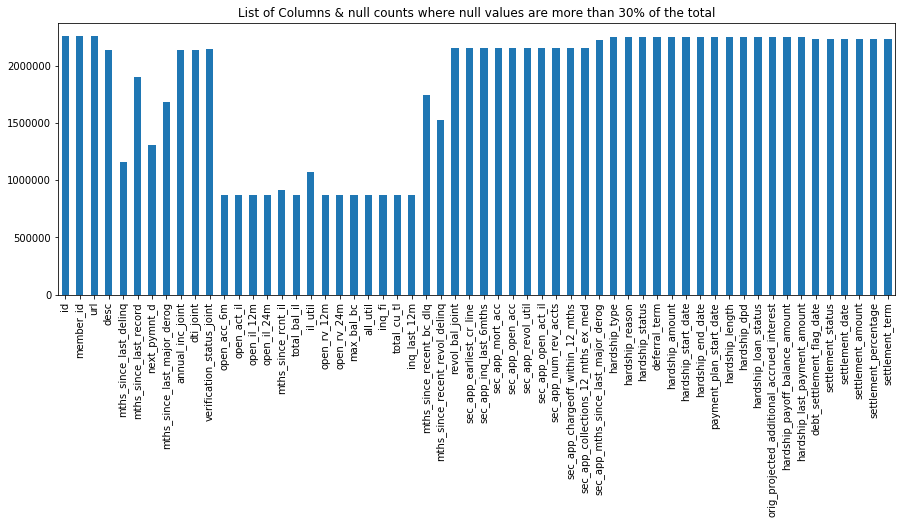

In [28]:
print (df.shape)
null_col = df.isnull().sum()
null_col = null_col[null_col.values >(0.3*len(df))]
print (null_col.shape[0])
plt.figure(figsize=(15,5))
null_col.plot(kind='bar')
plt.title('List of Columns & null counts where null values are more than 30% of the total')
plt.show()

From above plot, we can see that out of the 145 columns from the original dataset, only 58 columns have more than 30% of the rows populated. We will hence drop the rest of the columns, since there are too many null values.

In [33]:
df_dropped_col = df.drop(columns=list(null_col.index))
print (df_dropped_col.shape)

(2260668, 87)


Similarly, we check if there are any rows that have less than 30% of non-null values populated. We will go ahead and remove those rows

In [35]:
df_transposed = df_dropped_col.transpose()
null_rows = df_transposed.isnull().sum()
null_rows = null_rows[null_rows.values >(0.3*len(df_transposed))]
print (null_rows.shape)

(50585,)


In [37]:
df_dropped_row = df_dropped_col.drop(axis=0, labels=list(null_rows.index))
print (df_dropped_row.shape)

(2210083, 87)


After dropping null columns & rows, we check for columns where there is only one unique values. Those are not very useful in prediction, and hence we will remove those as well.

In [42]:
unique = df_dropped_row.nunique()
df_unique = df_dropped_row.drop(axis=1, labels=list(unique[unique==1].index))
print (unique[unique==1])
df_unique.head()

policy_code    1
dtype: int64


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,2500,2500,2500.0,36 months,13.56,84.92,C,C1,Chef,10+ years,...,0.0,1.0,0.0,60124.0,16901.0,36500.0,18124.0,N,Cash,N
1,30000,30000,30000.0,60 months,18.94,777.23,D,D2,Postmaster,10+ years,...,0.0,1.0,0.0,372872.0,99468.0,15000.0,94072.0,N,Cash,N
2,5000,5000,5000.0,36 months,17.97,180.69,D,D1,Administrative,6 years,...,0.0,0.0,0.0,136927.0,11749.0,13800.0,10000.0,N,Cash,N
3,4000,4000,4000.0,36 months,18.94,146.51,D,D2,IT Supervisor,10+ years,...,100.0,0.0,0.0,385183.0,36151.0,5000.0,44984.0,N,Cash,N
4,30000,30000,30000.0,60 months,16.14,731.78,C,C4,Mechanic,10+ years,...,0.0,0.0,0.0,157548.0,29674.0,9300.0,32332.0,N,Cash,N


Next, we handle a few specific columns. For employment length column, we fill the null values as 0, which could be self employeed borrowers. And we dropped the zip code column, as geographical information is already contained in state (addr_state) field. 

In [54]:
# print (df_unique.emp_length.value_counts(dropna=False))
df_unique.emp_length.fillna(0, inplace=True)
df_unique.drop(columns='zip_code',inplace=True)
df_unique.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2210083 entries, 0 to 2260667
Data columns (total 85 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   loan_amnt                   2210083 non-null  int64  
 1   funded_amnt                 2210083 non-null  int64  
 2   funded_amnt_inv             2210083 non-null  float64
 3   term                        2210083 non-null  object 
 4   int_rate                    2210083 non-null  float64
 5   installment                 2210083 non-null  float64
 6   grade                       2210083 non-null  object 
 7   sub_grade                   2210083 non-null  object 
 8   emp_title                   2046642 non-null  object 
 9   emp_length                  2210083 non-null  object 
 10  home_ownership              2210083 non-null  object 
 11  annual_inc                  2210083 non-null  float64
 12  verification_status         2210083 non-null  object 
 1

Next, we derive some columns based on business understanding.

In [58]:
# Calculate the ratio of loan to annual income, as an indication of the risk for the borrower
df_unique['loan_to_income_ratio'] = df_unique['loan_amnt'] / df_unique['annual_inc']
# Extract the year & month from issue_d and plot the average loan amount with respect to year
df_unique['issue_y'] = pd.to_datetime(df['issue_d'], format='%b-%Y', errors='coerce').apply(lambda x: x.year)
df_unique['issue_m'] = pd.to_datetime(df['issue_d'], format='%b-%Y', errors='coerce').apply(lambda x: x.month)
# print (df_unique.issue_m.value_counts())

10    225034
7     208939
11    202593
8     198676
12    190207
3     188737
5     176992
4     175987
6     172921
9     165204
1     158155
2     146638
Name: issue_m, dtype: int64


In [73]:
# pd.set_option('float_format', '{:f}'.format)
# df_unique.describe()

# Create bins for loan amount, annual income, interest rate
bins = [0, 5000, 10000, 15000, 20000, 25000,40000]
slot = ['0-5000', '5000-10000', '10000-15000', '15000-20000', '20000-25000','25000 and above']
df_unique['loan_amnt_range'] = pd.cut(df_unique['loan_amnt'], bins, labels=slot)

bins = [-1, 25000, 50000, 75000, 100000,110000000]
slot = ['0-25000', '25000-50000', '50000-75000', '75000-100000', '100000 and above']
df_unique['annual_inc_range'] = pd.cut(df_unique['annual_inc'], bins, labels=slot)

bins = [0, 7.5, 10, 12.5, 15,35]
slot = ['0-7.5', '7.5-10', '10-12.5', '12.5-15', '15 and above']
df_unique['int_rate_range'] = pd.cut(df_unique['int_rate'], bins, labels=slot)

df_unique.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2210083 entries, 0 to 2260667
Data columns (total 91 columns):
 #   Column                      Non-Null Count    Dtype   
---  ------                      --------------    -----   
 0   loan_amnt                   2210083 non-null  int64   
 1   funded_amnt                 2210083 non-null  int64   
 2   funded_amnt_inv             2210083 non-null  float64 
 3   term                        2210083 non-null  object  
 4   int_rate                    2210083 non-null  float64 
 5   installment                 2210083 non-null  float64 
 6   grade                       2210083 non-null  object  
 7   sub_grade                   2210083 non-null  object  
 8   emp_title                   2046642 non-null  object  
 9   emp_length                  2210083 non-null  object  
 10  home_ownership              2210083 non-null  object  
 11  annual_inc                  2210083 non-null  float64 
 12  verification_status         2210083 non-nu

In [ ]:
df = df_unique

## Distribution of loan amount, term, year

<ipython-input-120-2fb512dd40ec>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = plt.axes()


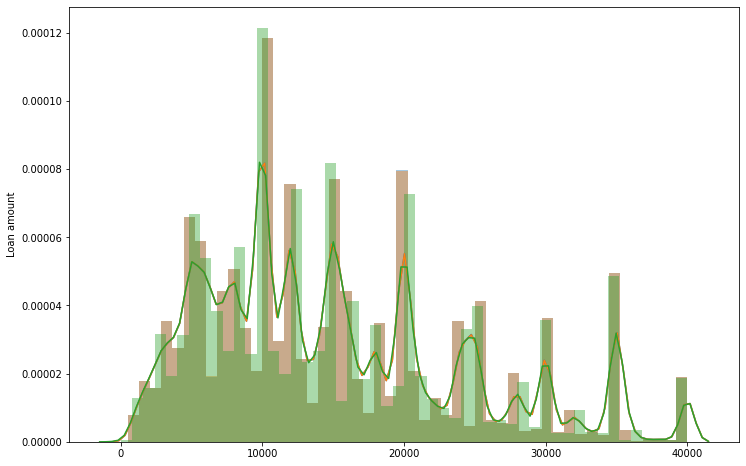

In [120]:
plt.figure(figsize=(12,8))
# Plot the distribution of loan amount applied by borrower
sns.distplot(df['loan_amnt'])
# Plot the distribution loan amount committeed
sns.distplot(df['funded_amnt'])
# Plot the distribution of loan amount committed by investors
sns.distplot(df['funded_amnt_inv'])
plt.ylabel('Loan amount')
ax1 = plt.axes()
x_axis = ax1.axes.get_xaxis()
x_label = x_axis.get_label()
x_label.set_visible(False)

 36 months    0.71207
 60 months    0.28793
Name: term, dtype: float64


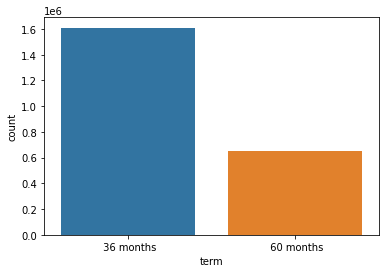

In [26]:
# Plot the term of the loans applied, in terms of percentage over all loans
print (df['term'].value_counts(normalize=True))
plt.figure(figsize=(12,8))
sns.countplot(df['term'])

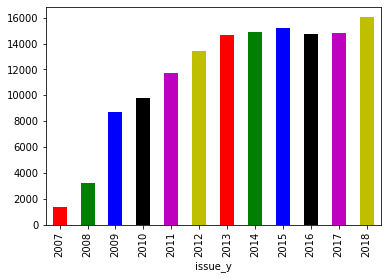

In [27]:
df.groupby('issue_y')['funded_amnt_inv'].mean().plot(kind='bar',color=['r', 'g', 'b', 'k', 'm', 'y'])
# sns.lineplot(df.groupby('issue_y')['funded_amnt_inv'].mean().index, df.groupby('issue_y')['funded_amnt_inv'].mean().values)

### Observation
* Loan amount applied follows a multi-nomial distribution, mostly falling within 10k - 20k range
* Loan amount applied and funded follows similar distributions, this means most loans applied by eligible borrowers are approved and funded by investor 
* _71%_ of the loans applied are for _36_ months, while _29%_ are for _60_ months.
* Average loan amount increases each year, with significant jump in _2009, peak around 2015-2018_. This is probably due to financial crisis in _2008_ , which resulted in low interet rate between _2009-2018_

In [28]:
# Inspect loan status
df['loan_status'].value_counts()

Fully Paid                                             1041952
Current                                                 919695
Charged Off                                             261655
Late (31-120 days)                                       21897
In Grace Period                                           8952
Late (16-30 days)                                         3737
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     31
Name: loan_status, dtype: int64

## Good Loan v.s. Bad Loan

* We categorise the loan as a bad loan if the loan status is any of the below 
* With this categorisation, we can see _13%_ of the loans are bad loans. Hence, this is a very __imbalanced dataset__, with large number of negatives if we are predicting bad loans
* However, we have to keep in mind that some of the "good" loans are still in the process of getting paid, especially loans that are more recent in this time horizon. Hence, we observe higher percentage of good loans from _2016-2018_. But these may turn bad later.

[Text(0, 0.5, '(%)')]

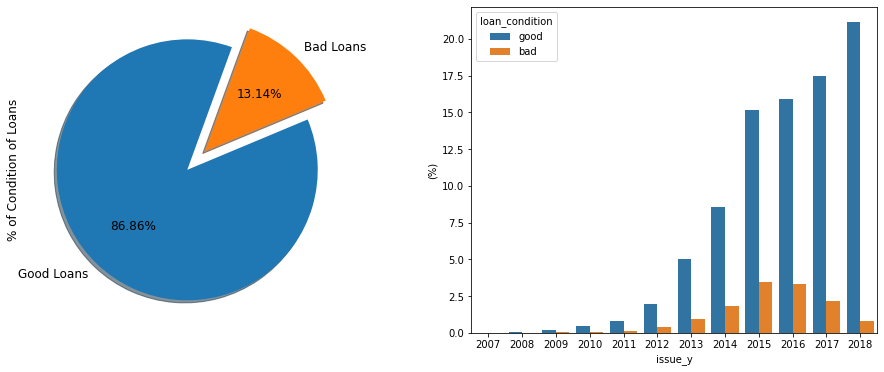

In [34]:
# We can categorise the loan as good / bad loan. 
# From the pie chart, 13% of the loans are bad loans
f, ax = plt.subplots(1,2, figsize=(16,6))
labels ="Good Loans", "Bad Loans"
bad_loan_statuses = ["Charged Off", "Default", "Does not meet the credit policy. Status:Charged Off", \
                     "In Grace Period", "Late (16-30 days)", "Late (31-120 days)"]
df['loan_condition'] = df['loan_status'].apply(lambda x: 'bad' if x in bad_loan_statuses else 'good')
df['loan_condition'].value_counts().plot(kind='pie', explode=[0,0.2], autopct='%1.2f%%',\
                                         ax=ax[0], labels=labels, fontsize=12, startangle=70, shadow=True)
ax[0].set_ylabel('% of Condition of Loans', fontsize=12)

sns.barplot(x="issue_y", y="loan_amnt", hue="loan_condition", data=df,\
            estimator=lambda x: len(x) / len(df) * 100)
ax[1].set(ylabel="(%)")

## Plotting loans for each state

We can see that Lending clubs borrowers are most active in the few states where economy is doing well, e.g. California, Texas, New York, Florida, Illinois etc. While the states with lowest amount of loans are mostly in the Mid-West, such as North Dakota, Idaho, South Dakota etc. 

Text(0.5, 0, 'State')

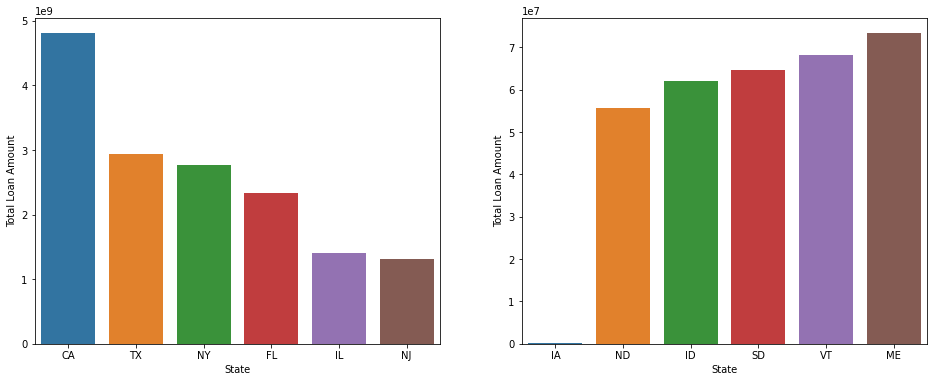

In [98]:
df['full_date'] = pd.to_datetime(df['issue_d'], format='%b-%Y', errors='coerce')

# Examine which state has the highest & lowest amount of loan in total
group_date = df.groupby(['addr_state'],as_index=False)['loan_amnt'].sum()
top_6_states = group_date.sort_values('loan_amnt',ascending=False).iloc[0:6]
btm_6_states = group_date.sort_values('loan_amnt').iloc[0:6]
fig, axs = plt.subplots(1,2, figsize=(16,6))
sns.barplot(x='addr_state', y='loan_amnt',data=top_6_states, ax=axs[0])
sns.barplot(x='addr_state', y='loan_amnt',data=btm_6_states, ax=axs[1])
axs[0].set_ylabel("Total Loan Amount")
axs[0].set_xlabel("State")
axs[1].set_ylabel("Total Loan Amount")
axs[1].set_xlabel("State")

### Observation
By plotting the loan condition splits for the top 6 & bottomr 6 states, we can see that states differ in the percentage of bad loans. 
* For the top 6 states in terms of loan amount, most of them have close to the overall average (~13%) of bad loans. 
* While for the bottom 6 states, the generally have less than the average % of bad loans. This could be due to these states being more financially conservative. 
* This means that state has a bearing on the percentage of good v.s. bad loans somehow

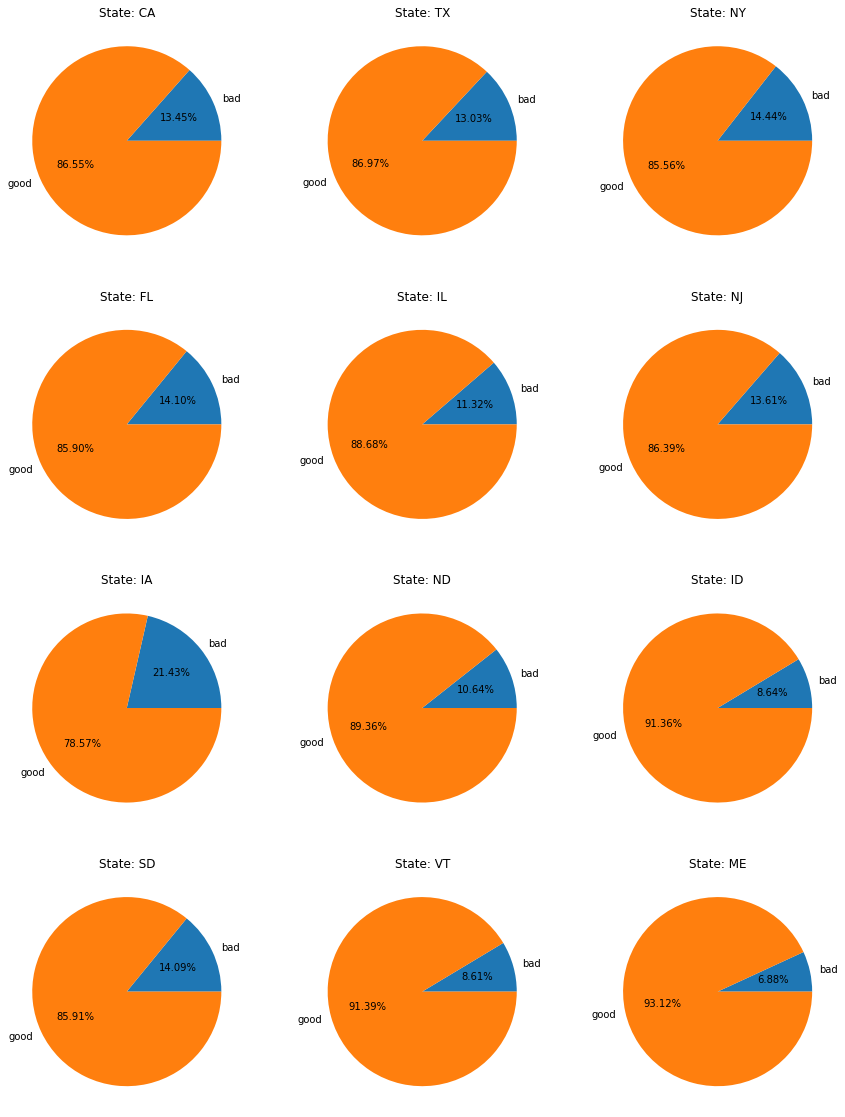

In [118]:
top_6_ls = list(top_6_states['addr_state'])
btm_6_ls = list(btm_6_states['addr_state'])
state_loan_condition = df.groupby('addr_state')['loan_condition'].value_counts(normalize=True).\
              unstack().reset_index().rename_axis(None, axis=1).set_index('addr_state')
plot_df = pd.concat([state_loan_condition.loc[top_6_ls], state_loan_condition.loc[btm_6_ls]])
# plot_df = state_loan_condition[~state_loan_condition.index.isin(['IA'])]
# print (plot_df.count())
# plot the pie good & bad loan percentage for the top 6 & bottom 6 states
fig = plt.figure(figsize=(15,20))
# print (state_loan_condition.count())
for i, (name, row) in enumerate(plot_df.iterrows()):
    ax = plt.subplot(4,3, i+1)
    ax.set_title("State: %s"%row.name)
    ax.set_aspect('equal')
    ax.pie(row, labels=row.index, autopct='%1.2f%%')

## Loan metrics by region
Hence, we decided to break down the country into four regions based on geography and plot some of the descriptive metrics for each region.

Text(0.5, 0, 'Year')

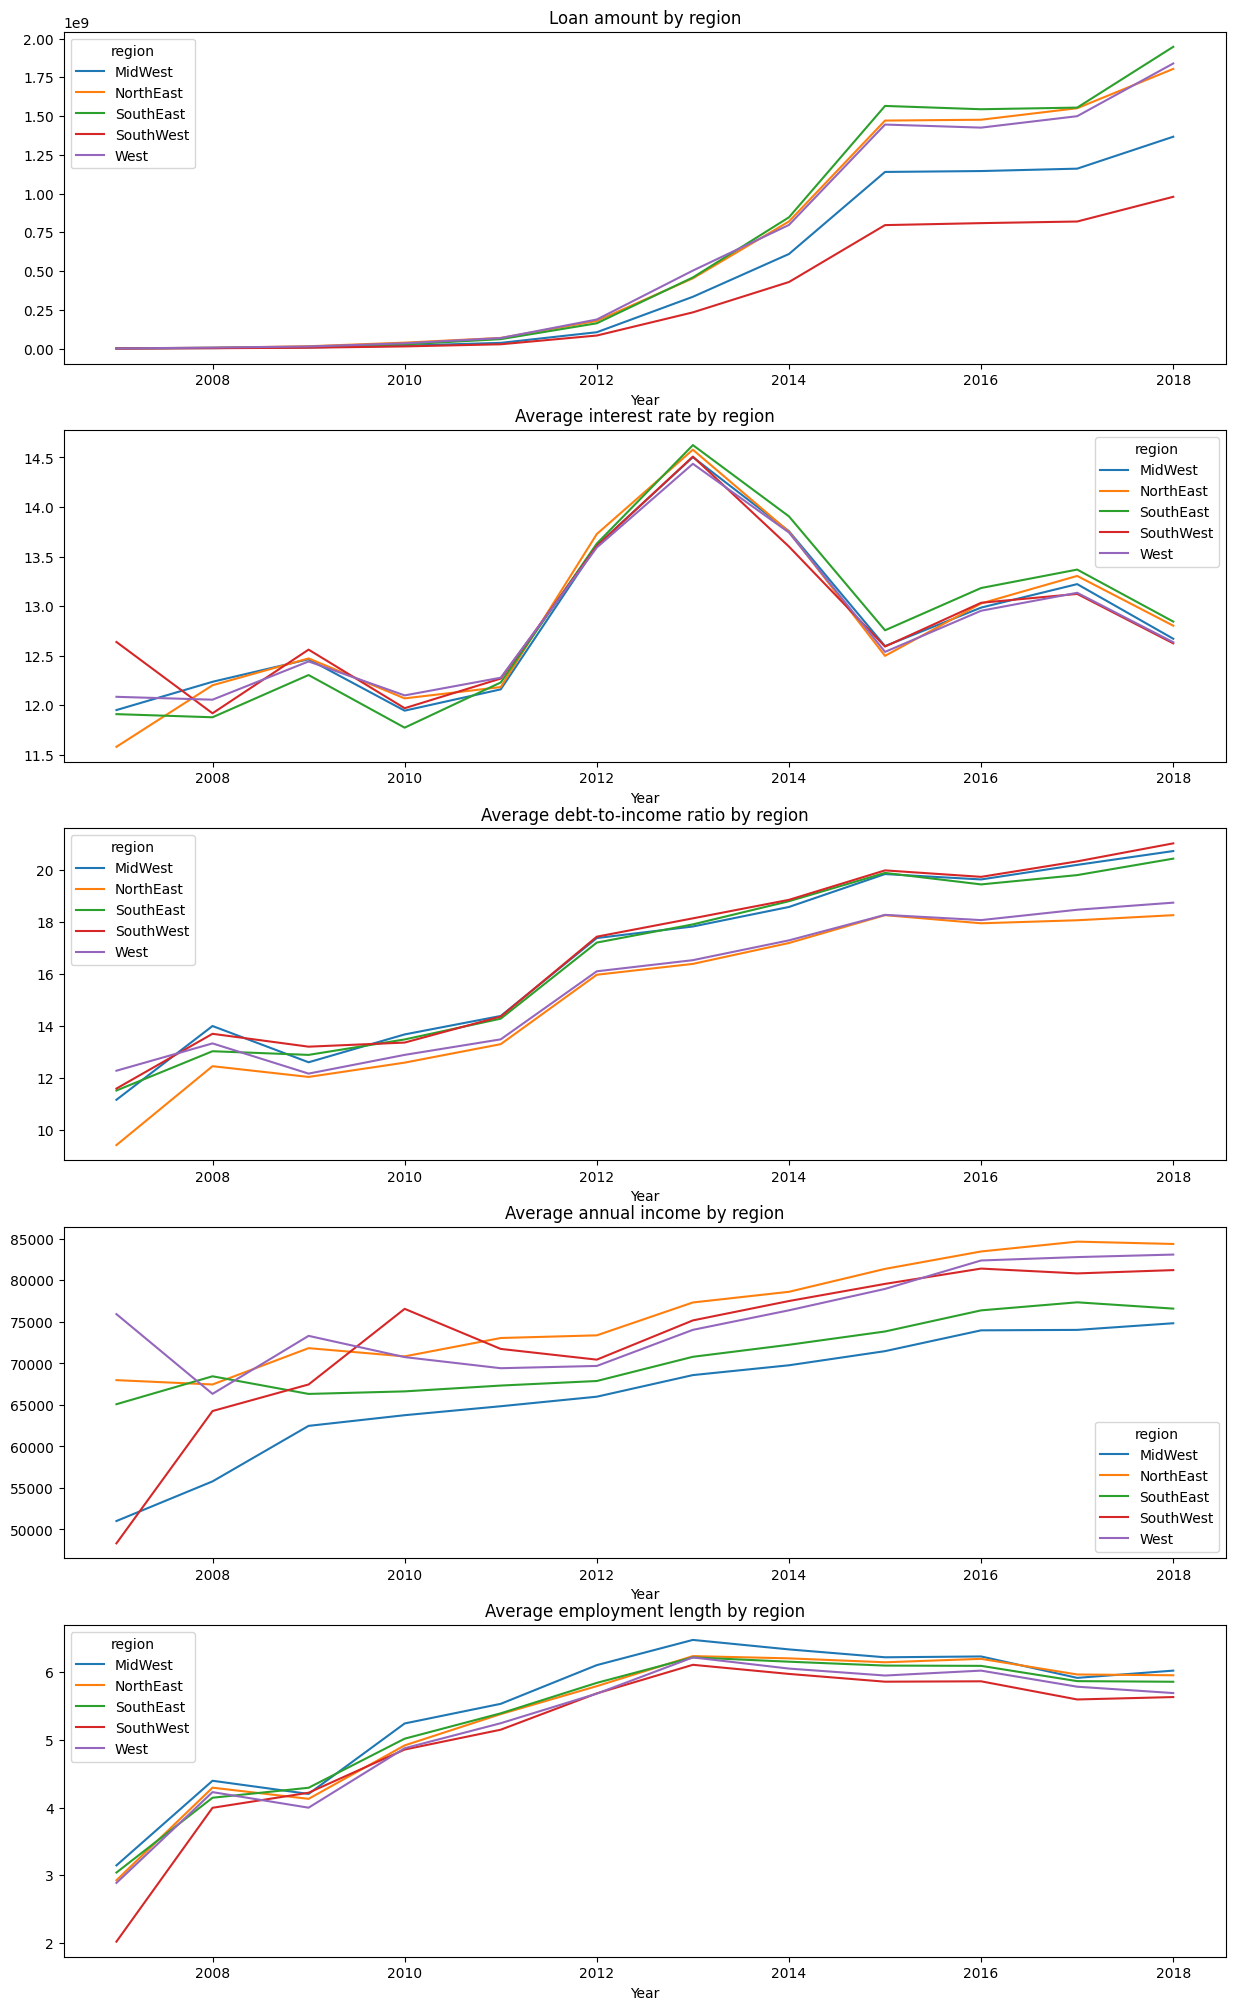

In [183]:
west = ['CA', 'OR', 'UT','WA', 'CO', 'NV', 'AK', 'MT', 'HI', 'WY', 'ID']
south_west = ['AZ', 'TX', 'NM', 'OK']
south_east = ['GA', 'NC', 'VA', 'FL', 'KY', 'SC', 'LA', 'AL', 'WV', 'DC', 'AR', 'DE', 'MS', 'TN' ]
mid_west = ['IL', 'MO', 'MN', 'OH', 'WI', 'KS', 'MI', 'SD', 'IA', 'NE', 'IN', 'ND']
north_east = ['CT', 'NY', 'PA', 'NJ', 'RI','MA', 'MD', 'VT', 'NH', 'ME']

df['region'] = np.nan

def finding_regions(state):
    if state in west:
        return 'West'
    elif state in south_west:
        return 'SouthWest'
    elif state in south_east:
        return 'SouthEast'
    elif state in mid_west:
        return 'MidWest'
    elif state in north_east:
        return 'NorthEast'

df['region'] = df['addr_state'].apply(finding_regions)
    
df['emp_length_int'] = np.nan

def update_emp_length_int(emp_length):
    emp_length_int = None
    if emp_length == '10+ years':
        emp_length_int = 10
    elif emp_length == '9 years':
        emp_length_int = 9
    elif emp_length == '8 years':
        emp_length_int = 8
    elif emp_length == '7 years':
        emp_length_int = 7
    elif emp_length == '6 years':
        emp_length_int = 6
    elif emp_length == '5 years': 
        emp_length_int = 5
    elif emp_length == '4 years':
        emp_length_int = 4
    elif emp_length == '3 years':
        emp_length_int = 3
    elif emp_length == '2 years': 
        emp_length_int = 2
    elif emp_length == '1 year':
        emp_length_int = 1
    elif emp_length == '< 1 year':
        emp_length_int = 0.5
    elif emp_length == 'n/a':
        emp_length_int = 0    
    return emp_length_int

df['emp_length_int'] = df['emp_length'].apply(update_emp_length_int)

# plt.style.use('dark_background')
f, ax = plt.subplots(5,1, figsize=(15,25))

grouped_df = df.groupby(['issue_y','region'])

loan_by_region = grouped_df.loan_amnt.sum()
# loan_by_region_date.head()
loan_by_region.unstack().plot(ax=ax[0], stacked=False)
ax[0].set_title('Loan amount by region')
ax[0].set_xlabel('Year')

int_rate_by_region = grouped_df.int_rate.mean()
int_rate_by_region.unstack().plot(ax=ax[1])
ax[1].set_title('Average interest rate by region')
ax[1].set_xlabel('Year')

dti_by_region = grouped_df.dti.mean()
dti_by_region.unstack().plot(ax=ax[2])
ax[2].set_title('Average debt-to-income ratio by region')
ax[2].set_xlabel('Year')

income_by_region = grouped_df.annual_inc.mean()
income_by_region.unstack().plot(ax=ax[3])
ax[3].set_title('Average annual income by region')
ax[3].set_xlabel('Year')

emp_length_by_region = grouped_df.emp_length_int.mean()
emp_length_by_region.unstack().plot(ax=ax[4])
ax[4].set_title('Average employment length by region')
ax[4].set_xlabel('Year')

### Observation
* SouthEast, West, NorthEast have the highest total loans amounts for most of the years, while SouthWest has the lowest 
* This also corresponds to the average interest rate per year, where SouthEast & NorthEast are the highest in most years. This means loans in SouthEast & NorthEast tend to give higher returns 
* Despite the low total loan amounts, SouthWest has the highest debt to income ratio. While NorthEast & West have rather low debt-to-income ratio
* NorthEast & West have the highest average annual income, which might explain their low debt-to-income ratio
* MidWest has the highest average employment length, but annual income are the lowest 

## Loan condition by region
Here, we plot the loan condition - good / bad, for each region, similar to how we plotted by states

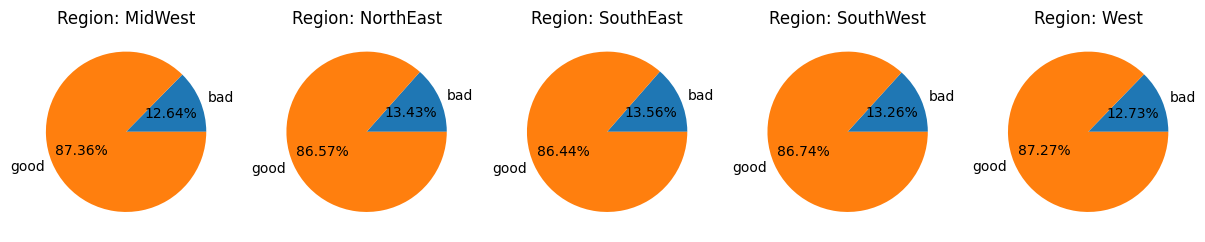

In [186]:
reg_loan_condition = df.groupby('region')['loan_condition'].value_counts(normalize=True).\
              unstack().reset_index().rename_axis(None, axis=1).set_index('region')
# plot the pie good & bad loan percentage for each region
fig = plt.figure(figsize=(15,20))
# print (state_loan_condition.count())
for i, (name, row) in enumerate(reg_loan_condition.iterrows()):
    ax = plt.subplot(1,5, i+1)
    ax.set_title("Region: %s"%row.name)
    ax.set_aspect('equal')
    ax.pie(row, labels=row.index, autopct='%1.2f%%')

Let's have a closer look at breakdown of __bad loans__ for each region. We can see that for each state, majority of the bad loans are charged off. 

loan_status  Charged Off  Default  \
region                              
MidWest            45202        9   
NorthEast          60827        7   
SouthEast          65460        5   
SouthWest          31833        4   
West               58333        6   

loan_status  Does not meet the credit policy. Status:Charged Off  \
region                                                             
MidWest                                                    142     
NorthEast                                                  190     
SouthEast                                                  184     
SouthWest                                                   79     
West                                                       166     

loan_status  In Grace Period  Late (16-30 days)  Late (31-120 days)  
region                                                               
MidWest                 1449                550                3609  
NorthEast               2356                957      

<Figure size 1500x4000 with 0 Axes>

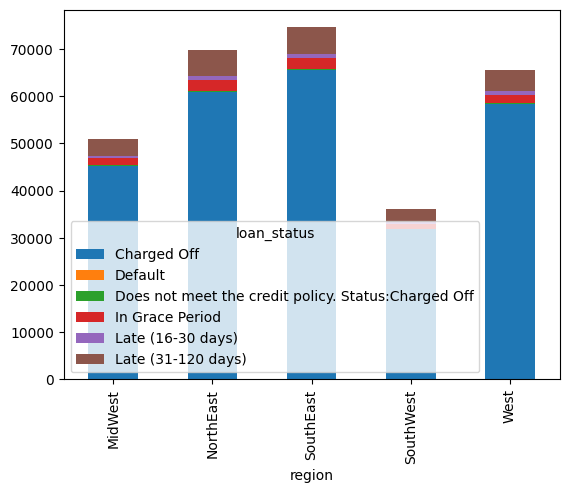

In [203]:
bad_loan_df = df[df['loan_condition']=='bad']
print (pd.crosstab(bad_loan_df['region'], bad_loan_df['loan_status']))
fig = plt.figure(figsize=(15,40))
bad_loan_df.groupby(['region','loan_status'])['loan_amnt'].count().unstack().plot(kind='bar',stacked=True)